# Assignment Set 2
by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU

In [4]:
#@title Data Injection
#@markdown here we also do the train test split
test_size = 0.35 #@param {type:"slider", min:0.10, max:0.35, step:0.01}
x = pd.read_csv('data/housing.csv').dropna()
y = x.pop('median_house_value')
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size)

##Cleaning Data

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


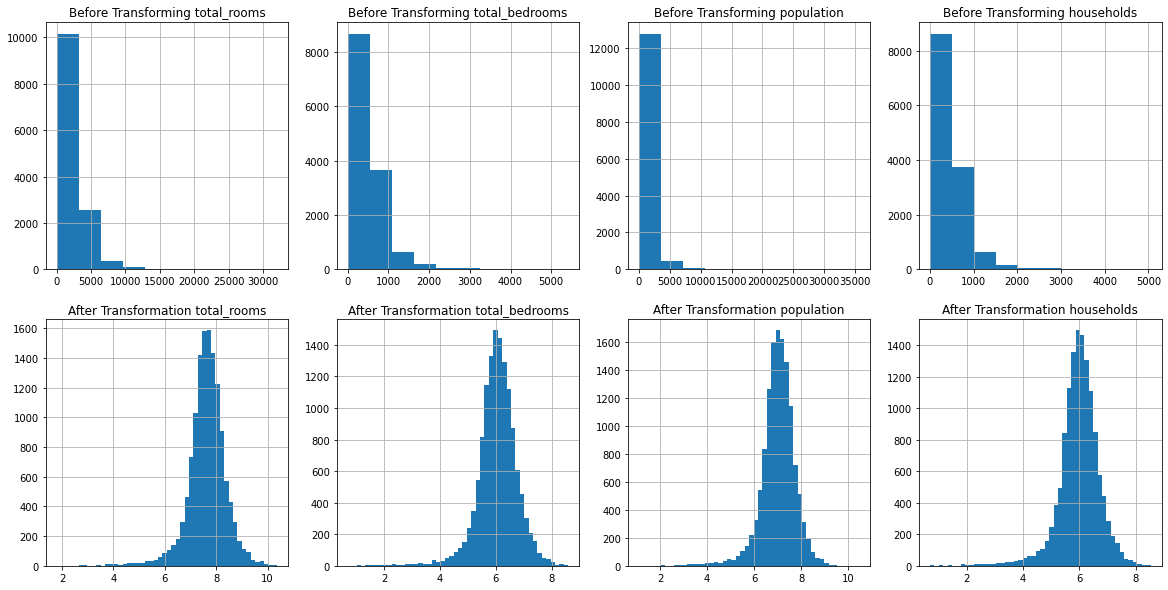

In [5]:
#@title total_rooms + total_bedrooms + population
plt.figure(figsize=(20,10))
for i,idx in enumerate(['total_rooms',
                        'total_bedrooms',
                        'population',
                        'households']):
    ax = plt.subplot(2,4,i+1)
    ax.set_title('Before Transforming '+idx)
    x_train.loc[:,idx].hist()

    ax = plt.subplot(2,4,i+5)
    ax.set_title('After Transformation '+idx)
    x_train.loc[:,idx] = np.log(x_train.loc[:,idx])
    x_test.loc[:,idx] = np.log(x_test.loc[:,idx]) # in the transformation pipeline
    x_train.loc[:,idx].hist(bins=50)
plt.show()

In [6]:
#@title ocean_proximity ordinal encoding
mapping = {'<1H OCEAN': 5, 
           'INLAND': 4,
           'ISLAND': 1,
           'NEAR BAY': 2,
           'NEAR OCEAN': 3}
x_train['ocean_proximity'] = x_train['ocean_proximity'].astype('category').map(mapping).astype('float')
x_test['ocean_proximity'] = x_test['ocean_proximity'].astype('category').map(mapping).astype('float') # in the transformation pipeline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) # in the transformation pipeline
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.1)

##  Building The Keras Models

In [296]:
part_maxout = keras.Sequential(layers=[layers.Reshape((-1,1)),
                         layers.MaxPooling1D(pool_size=stride,strides=stride),
                         layers.Flatten()],name='Maxout')

inputs = layers.Input(shape=(9))
l_ = layers.Dense(64,activation='linear')(inputs)
l_ = part_maxout(l_)
l_ = layers.Dense(64,activation='linear')(l_)
l_ = part_maxout(l_)
l_ = layers.Dense(64,activation='linear')(l_)
l_ = part_maxout(l_)
l_ = layers.Dense(32,activation='linear')(l_)
l_ = layers.Dropout(.2)(l_)
output = layers.Dense(1)(l_)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam", loss="mse")
model.summary()

Model: "functional_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense_181 (Dense)               (None, 64)           640         input_46[0][0]                   
__________________________________________________________________________________________________
Maxout (Sequential)             (None, 16)           0           dense_181[0][0]                  
                                                                 dense_182[0][0]                  
                                                                 dense_183[0][0]                  
______________________________________________________________________________________

In [ ]:
epochs = 30 #@param {type:"integer"}
model.fit(x_train, y_train, batch_size= 64,
          epochs=epochs,
          validation_data=(x_val,y_val),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1)

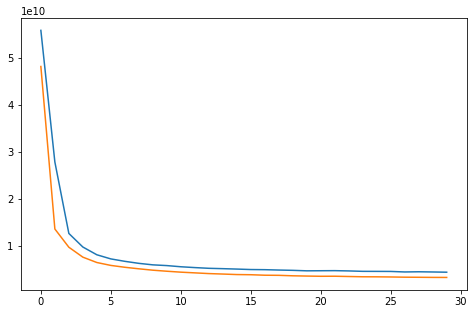

In [298]:
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [299]:
model.evaluate(x_test, y_test)

202/202 [==============================] - 0s 1ms/step - loss: 4038575360.0000


4038575360.0

## Second Keras Model

In [70]:
stride = 4

inputs = layers.Input(shape=(9))
l_ = layers.Dense(64,activation='linear')(inputs)

for i in range(64):
    l_ = layers.Dense(64,activation='linear')(l_)
    l_ = layers.Reshape((-1,1))(l_)
    l_ = layers.MaxPooling1D(pool_size=stride,strides=stride)(l_)
    l_ = layers.Flatten()(l_)
    
l_ = layers.Dense(32,activation='linear')(l_)
# l_ = layers.Dropout(.2)(l_)
output = layers.Dense(1)(l_)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam", loss="mse")
model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 9)]               0         
_________________________________________________________________
dense_328 (Dense)            (None, 64)                640       
_________________________________________________________________
dense_329 (Dense)            (None, 64)                4160      
_________________________________________________________________
reshape_239 (Reshape)        (None, 64, 1)             0         
_________________________________________________________________
max_pooling1d_238 (MaxPoolin (None, 16, 1)             0         
_________________________________________________________________
flatten_238 (Flatten)        (None, 16)                0         
_________________________________________________________________
dense_330 (Dense)            (None, 64)              

In [71]:
epochs = 15 #@param {type:"integer"}
model.fit(x_train, y_train, batch_size= 64,
          epochs=epochs,
          validation_data=(x_val,y_val),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1)

Epoch 1/15
208/208 [==============================] - 3s 15ms/step - loss: 16408558592.0000 - val_loss: 6304883712.0000
Epoch 2/15
208/208 [==============================] - 2s 10ms/step - loss: 4838631424.0000 - val_loss: 5236792320.0000
Epoch 3/15
208/208 [==============================] - 2s 10ms/step - loss: 4207510016.0000 - val_loss: 5010836480.0000
Epoch 4/15
208/208 [==============================] - 2s 10ms/step - loss: 4217002752.0000 - val_loss: 4406093824.0000
Epoch 5/15
208/208 [==============================] - 2s 10ms/step - loss: 3790684672.0000 - val_loss: 5364376576.0000
Epoch 6/15
208/208 [==============================] - 2s 10ms/step - loss: 3750335232.0000 - val_loss: 4590174720.0000
Epoch 7/15
208/208 [==============================] - 2s 10ms/step - loss: 3767083520.0000 - val_loss: 4065990400.0000
Epoch 8/15
208/208 [==============================] - 2s 10ms/step - loss: 3432837120.0000 - val_loss: 4246202368.0000
Epoch 9/15
208/208 [===========================

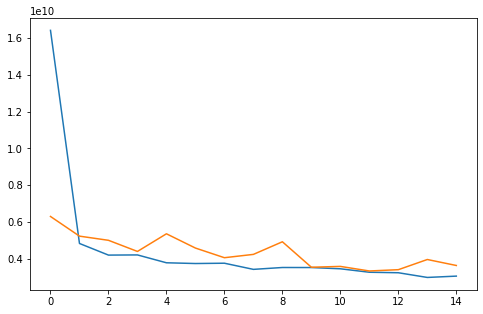

In [72]:
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [73]:
#@markdown No fewer loss obtained with deeper (up to 128) neither with breader (up to 128) nor with longer strides (up to 8) 
model.evaluate(x_test, y_test)

202/202 [==============================] - 1s 4ms/step - loss: 3026082816.0000


3026082816.0